In [7]:
import os
import pandas as pd
import numpy as np

In [8]:
# import the data
train = pd.read_csv('..\\datasets\\intermediate\\hms-harmful-brain-activity-classification\\train.csv')

In [9]:
train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


## Dataset Description

The dataset contains information about harmful brain activity classification. Here are the columns in the dataset:

- `eeg_id`: A unique identifier for the entire EEG recording.
- `eeg_sub_id`: An ID for the specific 50-second long subsample this row's labels apply to.
- `eeg_label_offset_seconds`: The time between the beginning of the consolidated EEG and this subsample.
- `spectrogram_id`: A unique identifier for the entire EEG recording.
- `spectrogram_sub_id`: An ID for the specific 10-minute subsample this row's labels apply to.
- `spectogram_label_offset_seconds`: The time between the beginning of the consolidated spectrogram and this subsample.
- `label_id`: An ID for this set of labels.
- `patient_id`: An ID for the patient who donated the data.
- `expert_consensus`: The consensus annotator label. Provided for convenience only.
- `[seizure/lpd/gpd/lrda/grda/other]_vote`: The count of annotator votes for a given brain activity class. The full names of the activity classes are as follows:
    - `lpd`: Lateralized Periodic Discharges
    - `gpd`: Generalized Periodic Discharges
    - `lrd`: Lateralized Rhythmic Delta Activity
    - `grda`: Generalized Rhythmic Delta Activity

This information provides valuable insights into the dataset and helps in understanding the different aspects of harmful brain activity classification.


#### Explaining The Data

In [10]:
print(f"There are {len(train['eeg_id'].unique())} unique EEGs in the dataset")
print(f"There are {len(train['spectrogram_id'].unique())} unique spectrogram_ids in the dataset")
print(f"There are {len(train['patient_id'].unique())} unique patients in the dataset")

There are 17089 unique EEGs in the dataset
There are 11138 unique spectrogram_ids in the dataset
There are 1950 unique patients in the dataset


##### Question: We are given `train.csv` with 106,800 rows, but there are only 17,089 unique `eeg_ids`, 11,138 unique `spectrogram_ids`, and 1,950 unique patients. What is going on??
##### Answer: 
Each row of the `train.csv` file represents a window of time from one specific patient. The corresponding EEG and spectrogram data can be found in separate Kaggle parquet files. 

In summary, the dataset is structured in such a way that each row in the `train.csv` file corresponds to a specific time window of EEG data for a patient. The detailed data for each of these time windows is stored in separate parquet files.

This design allows for efficient storage and retrieval of the data, as well as the ability to analyze specific time windows of EEG data for different patients.


## Understanding the Time Windows

Each row in the `train.csv` file represents a specific window in time for a particular `patient_id`. The middle timestamp of each window is not provided in the dataframe, but we can calculate it based on the given information.

The EEG time window has a length of 50 seconds, and the Spectrogram time window has a length of 600 seconds. Both windows share the same center timestamp. In this competition, our task is to predict the event occurring in the middle 10 seconds of both these time windows.

Let's break it down:

- **Center Timestamp**: T
- **EEG Time Window**: [T-25 : T+25]
- **Spectrogram Time Window**: [T-300 : T+300]
- **Event Prediction Window**: [T-5 : T+5]

By focusing on the event prediction window, we aim to identify the specific event occurring within this 10-second interval.

This approach allows us to analyze and predict events accurately within the given time windows, providing valuable insights into harmful brain activity classification.

The EEG parquet files are longer than 50 seconds. One EEG parquet file has multiple rows of time windows inside it. Similarily, the Spectrogram parquet files are longer than 600 seconds. One Spectrogram parquet file has multiple rows of time windows inside it.

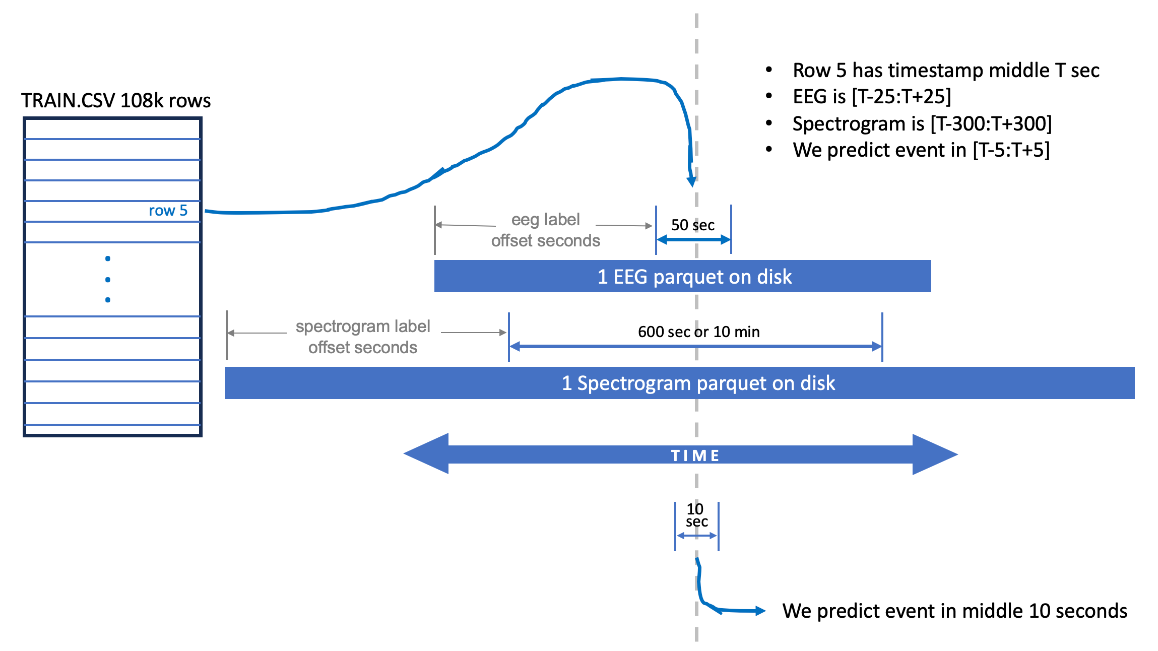

In [12]:
GET_ROW = 0
EEG_PATH = '..\\datasets\\intermediate\\hms-harmful-brain-activity-classification\\train_eegs\\'
SPEC_PATH = '..\\datasets\\intermediate\\hms-harmful-brain-activity-classification\\train_spectrograms\\'

row = train.iloc[GET_ROW]

eeg = pd.read_parquet(f'{EEG_PATH}{row.eeg_id}.parquet')
eeg_offset = int( row.eeg_label_offset_seconds )
eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]

spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
spec_offset = int( row.spectrogram_label_offset_seconds )
spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                     &(spectrogram.time<spec_offset+600)]


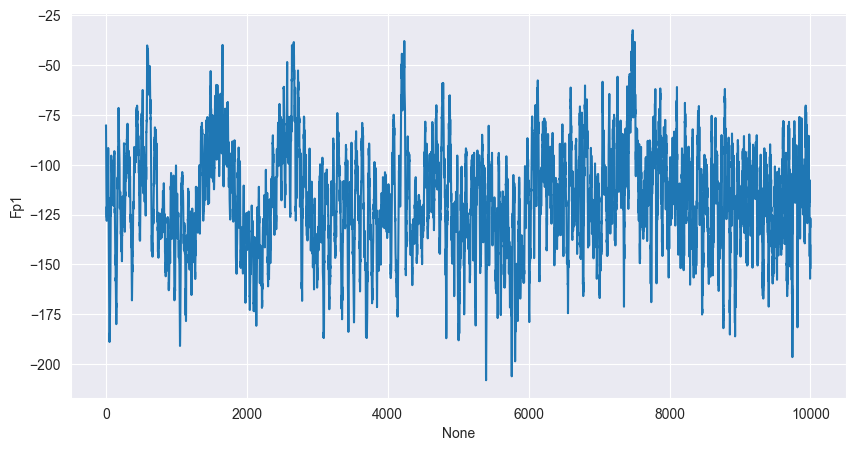

In [18]:
# Let's plot the EEG and the spectrogram with librosa
import matplotlib.pyplot as plt
import seaborn as sns

fig= plt.subplots(figsize=(10, 5))
sns.lineplot(x=eeg.index, y=eeg.iloc[:,0])
sns.set_style('darkgrid')
plt.show()


In [23]:
spectrogram

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,4.26,10.98,9.05,13.65,11.49,8.930000,18.840000,19.260000,19.240000,...,0.31,0.17,0.28,0.19,0.24,0.27,0.29,0.16,0.22,0.19
1,3,2.65,3.97,12.18,13.26,14.21,13.230000,9.650000,8.110000,11.280000,...,0.15,0.13,0.14,0.24,0.24,0.36,0.35,0.31,0.36,0.40
2,5,4.18,4.53,8.77,14.26,13.36,16.559999,19.219999,17.510000,22.650000,...,0.29,0.21,0.16,0.25,0.28,0.28,0.34,0.48,0.44,0.48
3,7,2.41,3.21,4.92,8.07,5.97,12.420000,10.820000,14.960000,21.809999,...,0.33,0.51,0.49,0.64,0.58,0.42,0.32,0.31,0.32,0.33
4,9,2.29,2.44,2.77,4.62,5.39,7.080000,9.840000,12.270000,14.410000,...,0.44,0.38,0.48,0.63,0.45,0.45,0.49,0.33,0.31,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,591,5.26,7.41,10.16,7.25,15.35,27.590000,28.650000,27.600000,30.690001,...,0.09,0.17,0.11,0.09,0.10,0.08,0.07,0.17,0.17,0.24
296,593,5.17,7.17,10.05,13.47,13.22,11.560000,29.790001,24.660000,23.379999,...,0.06,0.06,0.05,0.11,0.09,0.08,0.16,0.21,0.20,0.20
297,595,1.87,3.59,8.69,7.59,8.33,11.880000,12.690000,16.360001,24.240000,...,0.09,0.07,0.07,0.06,0.06,0.07,0.08,0.10,0.10,0.10
298,597,3.27,5.63,9.46,11.19,11.98,12.260000,9.240000,7.030000,8.660000,...,0.12,0.08,0.06,0.04,0.04,0.06,0.05,0.08,0.13,0.14


In [26]:
eeg

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-80.519997,-70.540001,-80.110001,-108.750000,-120.330002,-88.620003,-101.750000,-104.489998,-99.129997,-90.389999,-97.040001,-77.989998,-88.830002,-112.120003,-108.110001,-95.949997,-98.360001,-121.730003,-106.449997,7.920000
1,-80.449997,-70.330002,-81.760002,-107.669998,-120.769997,-90.820000,-104.260002,-99.730003,-99.070000,-92.290001,-96.019997,-84.500000,-84.989998,-115.610001,-103.860001,-97.470001,-89.290001,-115.500000,-102.059998,29.219999
2,-80.209999,-75.870003,-82.050003,-106.010002,-117.500000,-87.489998,-99.589996,-96.820000,-119.680000,-99.360001,-91.110001,-99.440002,-104.589996,-127.529999,-113.349998,-95.870003,-96.019997,-123.879997,-105.790001,45.740002
3,-84.709999,-75.339996,-87.480003,-108.970001,-121.410004,-94.750000,-105.370003,-100.279999,-113.839996,-102.059998,-95.040001,-99.230003,-101.220001,-125.769997,-111.889999,-97.459999,-97.180000,-128.940002,-109.889999,83.870003
4,-90.570000,-80.790001,-93.000000,-113.870003,-129.960007,-102.860001,-118.599998,-101.099998,-107.660004,-102.339996,-98.510002,-95.300003,-88.930000,-115.639999,-99.800003,-97.500000,-88.730003,-114.849998,-100.250000,97.769997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-140.039993,-128.100006,-137.339996,-160.830002,-153.630005,-136.279999,-137.009995,-93.349998,-145.130005,-155.830002,-124.650002,-123.250000,-127.709999,-169.759995,-68.489998,-117.669998,-69.239998,-115.309998,-123.860001,65.010002
9996,-152.169998,-161.449997,-173.210007,-165.320007,-143.570007,-124.150002,-127.339996,-87.309998,-160.919998,-158.360001,-121.870003,-129.550003,-121.470001,-120.339996,-68.029999,-135.130005,-105.190002,-114.330002,-121.029999,47.090000
9997,-149.619995,-147.479996,-171.960007,-152.589996,-137.279999,-105.550003,-122.220001,-80.010002,-156.039993,-155.119995,-116.360001,-118.099998,-113.690002,-102.760002,-67.839996,-120.410004,-109.099998,-116.419998,-119.099998,95.589996
9998,-126.860001,-122.889999,-125.879997,-130.339996,-134.779999,-134.350006,-127.080002,-76.739998,-137.649994,-146.800003,-111.720001,-114.199997,-106.739998,-104.699997,-60.240002,-154.119995,-129.639999,-110.029999,-116.239998,72.980003


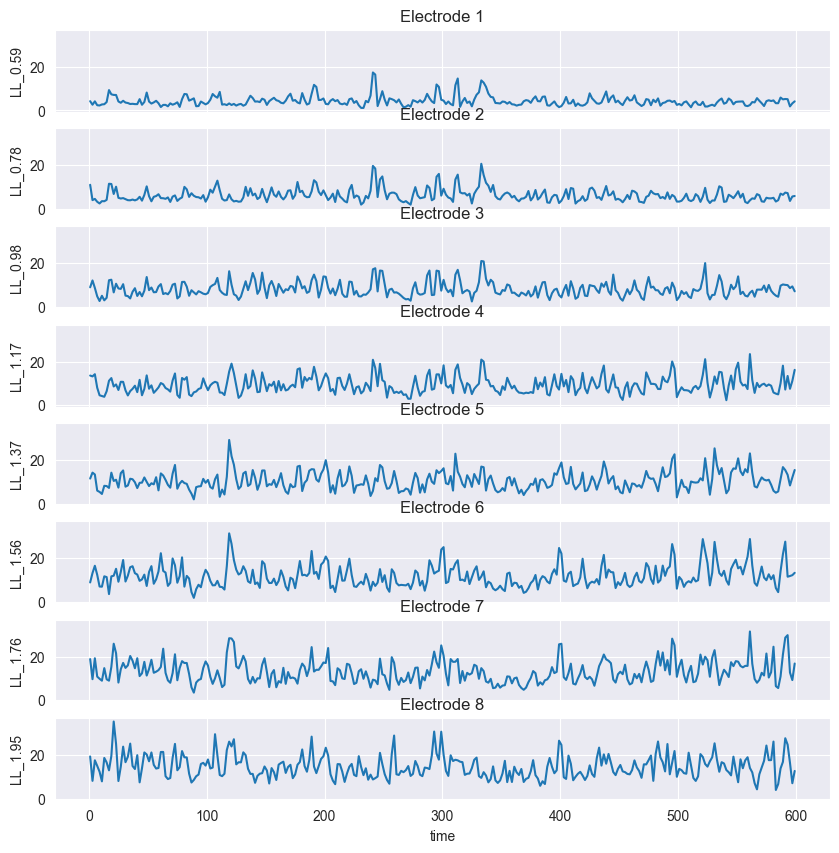

In [25]:
# Let's visualize the spectrogram. Each column except the time column is a brain signal from another electrode so we will plot each of them separately in one big plot

fig, ax = plt.subplots(8, 1, figsize=(10, 10), sharex=True, sharey=True)
for i in range(8):
    sns.lineplot(x=spectrogram.time, y=spectrogram.iloc[:,i+1], ax=ax[i])
    ax[i].set_title(f'Electrode {i+1}')
